In [1]:
%pylab inline
from astropy.constants import pc
data = np.genfromtxt('Pos_raw_andLlya.txt')

#taking data from the simulation
Pos_Mpc = data[:,0:3]
L_lya = data[:,3] #case B simple Lya (10**42 SFR)
SFR = data[:,4]
Mass_stel = data[:,5]

Populating the interactive namespace from numpy and matplotlib


9.523809523809524e+39
0.07999788224697113 -15.297598750223706
0.7999169230461121 -17.79751473669285
7.92720365524292 -20.28770256378038


Text(0, 0.5, 'M$_1500$')

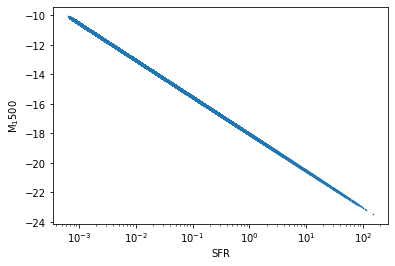

In [11]:
#eliminating halos without SF
L_lya   = L_lya[SFR!=0]
Pos_Mpc = Pos_Mpc[SFR!=0]
Mass_stel = Mass_stel[SFR!=0]
SFR     = SFR[SFR!=0]

#L_UV starting from Kennicut and Madau
L_1500 = SFR*3*10**10/(1.4*10**(-28)*1500*1500*10**(-8)) #[erg/s/A] following Kennicut, also in Garel2015
print(3*10**10/(1.4*10**(-28)*1500*1500*10**(-8))) #in Garel 1.4*10**40

M_1500 = -2.5*np.log10(L_1500*(1500*10**(-8))*1500/(3*10**10)/(4*np.pi*(10*pc.value*10**2)**2))-48.6

print(np.max(SFR[SFR<0.08]), np.min(M_1500[SFR<0.08]))
print(np.max(SFR[SFR<0.8]), np.min(M_1500[SFR<0.8]))
print(np.max(SFR[SFR<8]), np.min(M_1500[SFR<8]))

plt.scatter(SFR, M_1500, s=0.5)
plt.xscale('log')
plt.xlabel('SFR')
plt.ylabel(r'M$_1500$')

## select the function

Text(0.5, 1.0, 'pdf(f|SFR = 1)')

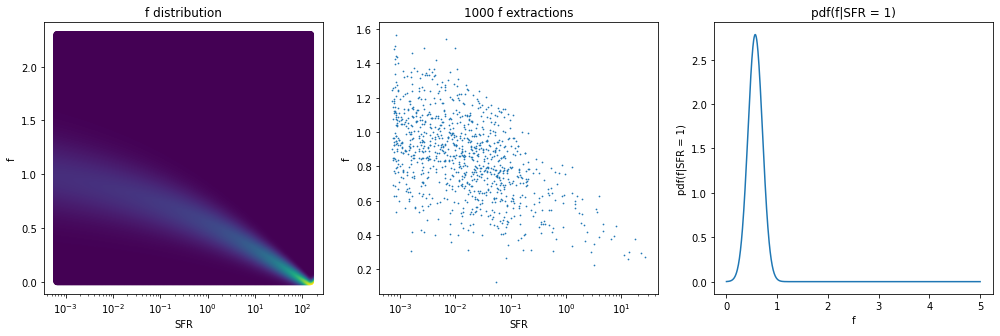

In [3]:
from scipy.stats import norm
from scipy.integrate import quad
from progress.bar import Bar

#0 = only arctan
#1 = arctan + gaus at 0
#2 = gaus with sigma=rarctan
#3 = 2nd degree pol
#4 = gaus with a 2nd degree poly as a sigma
select = 0


SFR_log = np.log10(SFR)
sfr_min = np.min(SFR_log)#10**(-2)
sfr_max = np.max(SFR_log)
delta=sfr_max-sfr_min
f = np.zeros(len(L_lya))

x_linsp = np.linspace(0,5, 1000)
a=4


def gaus2(x,c, mean_0, sigma_0, mean_1, sigma_1):
    fun = c*norm.pdf(x,mean_0,sigma_0)+norm.pdf(x, mean_1, sigma_1)
    return fun

def zero_to_pi(sfr, sfr_min, sfr_max):
    SFR_log = np.log10(sfr)
    return (SFR_log-sfr_min)/(sfr_max-sfr_min)*np.pi/2

def zero_to_one(sfr, sfr_min, sfr_max):
    SFR_log = np.log10(sfr)
    return (SFR_log-sfr_min)/(sfr_max-sfr_min)

def f_dist(sfr,xx, sfr_min,sfr_max, c):
    x_var = zero_to_pi(sfr, sfr_min, sfr_max)  
    
    if select==0:
        mean_1 = np.arctan(np.pi/2-x_var)
        sigma_1 = 0.2*mean_1+0.03
        mean_0 = 0
        sigma_0 = 1000
        fun = gaus2(xx,0,mean_0,sigma_0, mean_1, sigma_1)
        
    if select==1:
        mean_1 = 1.5*np.arctan(np.pi/2-x_var)
        sigma_1 = 0.2*mean_1+0.03
        mean_0 = 0
        sigma_0 = 0.7*mean_1+0.01
        fun = gaus2(xx,c,mean_0,sigma_0, mean_1, sigma_1)
    
    if select==2:
        sigma_g = np.arctan(np.pi/2 -x_var)+0.01
        fun = norm.pdf(xx,0, sigma_g)
    
    if select==3:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        mean_1 = -x_var**2+1
        sigma_1 = 0.2*mean_1+0.03
        fun = norm.pdf(xx, mean_1, sigma_1)
        
    if select==4:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        mean_1 = 0.
        sigma_1 =(-x_var**2+1)+0.0001
        fun = norm.pdf(xx, mean_1, sigma_1)
        
    return fun

max_ext = 2.3
if select==1:
    max_ext=4
if select==2:
    max_ext=6
if select==4:
    max_ext=5.5

fig,ax = plt.subplots(1,3, figsize=(17,5))
aa = np.logspace(sfr_min,sfr_max, 500)
bb = np.linspace(0,max_ext, 500)
AA, BB = np.meshgrid(aa,bb)
AA = AA.reshape(-1)
BB = BB.reshape(-1)
color = f_dist(AA,BB,sfr_min,sfr_max,a)

max_color = np.max(f_dist(AA,BB,sfr_min,sfr_max,a))
ax[0].scatter(AA,BB, c=color)
rand_x = np.random.uniform(0,max_ext,len(SFR_log))
rand_y = np.random.uniform(0, max_color+0.01, len(SFR_log))
ind_change = np.where(rand_y>f_dist(SFR, rand_x, sfr_min, sfr_max,a))

while len(ind_change[0])!=0:
    #print(len(ind_change[0]))
    rand_x[ind_change[0]] = np.random.uniform(0, max_ext, len(ind_change[0]))
    rand_y[ind_change[0]] = np.random.uniform(0, max_color+0.000001, len(ind_change[0]))
    ind_change = np.where(rand_y>f_dist(SFR, rand_x, sfr_min, sfr_max, a))
    
f = rand_x

#plt.scatter(SFR, f)
ax[0].set_xscale('log')
ax[0].set_xlabel('SFR')
ax[0].set_ylabel('f')
ax[0].set_title('f distribution')

rand_indd = np.random.randint(0,len(L_lya), size=1000)
ax[1].scatter(SFR[rand_indd], f[rand_indd], s=0.5)
ax[1].set_xscale('log')
ax[1].set_xlabel('SFR')
ax[1].set_ylabel('f')
ax[1].set_title('1000 f extractions')


ax[2].plot(x_linsp, f_dist(1, x_linsp, sfr_min, sfr_max, a))
ax[2].set_xlabel('f')
ax[2].set_ylabel('pdf(f|SFR = 1)')
ax[2].set_title('pdf(f|SFR = 1)')

(array([1.0000e+00, 9.0000e+00, 1.2500e+02, 3.4520e+03, 2.1832e+04,
        2.1721e+04, 2.2107e+04, 2.3814e+04, 2.7107e+04, 2.8674e+04,
        2.5888e+04, 1.8852e+04, 1.1158e+04, 6.5580e+03, 4.0510e+03,
        2.6560e+03, 1.7220e+03, 9.2100e+02, 4.8400e+02, 1.1700e+02]),
 array([37.74262898, 38.01230663, 38.28198428, 38.55166193, 38.82133958,
        39.09101723, 39.36069488, 39.63037253, 39.90005018, 40.16972783,
        40.43940548, 40.70908313, 40.97876078, 41.24843843, 41.51811608,
        41.78779373, 42.05747138, 42.32714903, 42.59682668, 42.86650433,
        43.13618198]),
 <BarContainer object of 20 artists>)

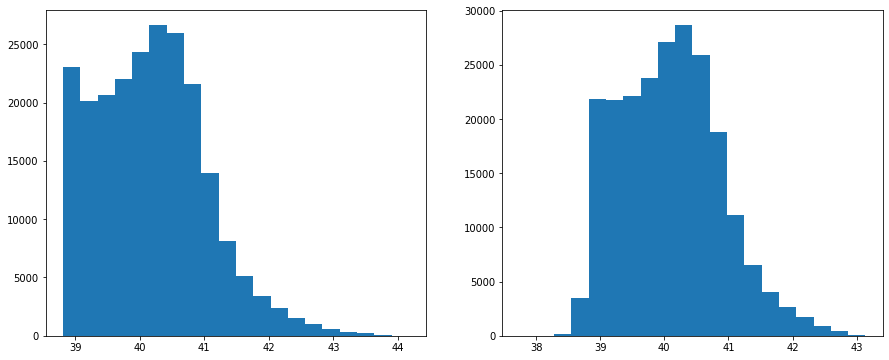

In [4]:
L_lya_obs = L_lya*f

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].hist(np.log10(L_lya), bins=20)
ax[1].hist(np.log10(L_lya_obs[L_lya_obs!=0]), bins=20)

In [5]:
from lum_func import *
from corr_functions import * 

###LUMINOSITY FUNCTION
av_bin, counts, zeros = Lya_lumfunction(L_lya, 20) #the original case B
av_bin_obs, counts_obs, zeros_obs = Lya_lumfunction(L_lya_obs[L_lya_obs>0], 40) #the corrected one

###CORRELATION FUNCTION
N_boot = 1
bins = np.logspace(np.log10(0.1), np.log10(10), 15)
xi = np.zeros((N_boot, len(bins)-1))

for i in range(N_boot):
    bins_cen, xi[i], _ = corr_func(500, bins, Pos_Mpc[L_lya_obs>10**39], 0, 100, False)

med_xi = np.median(xi, axis=0)
sigma_xi = (np.percentile(xi, 75, axis=0) - np.percentile(xi, 25, axis=0))*0.7413

###EW
EW = L_lya_obs/L_1500*(1500/1216)**(-1.5)

###EW fraction to compare with Kusakabe
Kusakabe_bins = np.array([-21.5, -20, -19, -18, -17])
Kusakabe_bins_cen = (Kusakabe_bins[1:]+Kusakabe_bins[:-1])/2

#dividing galaxies in bins of M_1500
ind_bins = [[] for i in range(len(Kusakabe_bins_cen))]
for i in range(len(Kusakabe_bins)-1):
    ind_bins[i] = np.where(np.logical_and(M_1500>=Kusakabe_bins[i], M_1500<Kusakabe_bins[i+1]))
    
#dividing galaxies in bins of EW
EW_thresh = [25,45,65,85]
EW_fraction = np.zeros([len(Kusakabe_bins_cen), len(EW_thresh)])
for j in range(len(Kusakabe_bins_cen)):
    for i in range(len(EW_thresh)):
        EW_fraction[j,i] = len(np.where(EW[ind_bins[j]]>EW_thresh[i])[0])/len(ind_bins[j][0])


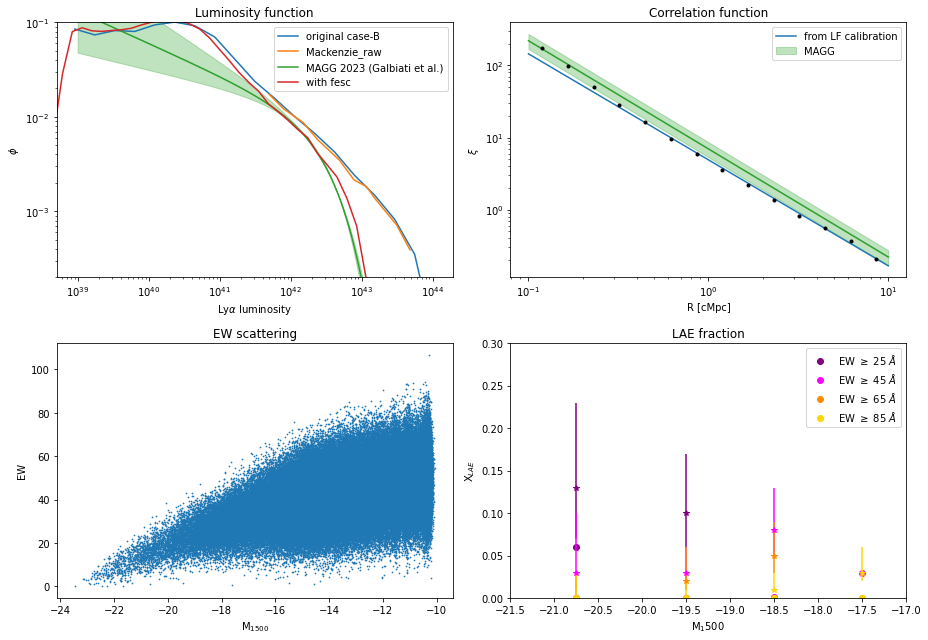

In [6]:
fig, ax = plt.subplots(2,2, figsize=(13,9))
ax=ax.reshape(-1)

##LF
ax[0].plot(av_bin, counts, label='original case-B')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Luminosity function')
ax[0].set_ylim(2*10**(-4), 10**(-1))
ax[0].set_xlim()
ax[0].set_xlabel(r'Ly$\alpha$ luminosity')
ax[0].set_ylabel(r'$\phi$')

#mackenzie_raw
mack_lf = np.genfromtxt('Mackenzie.txt')
ax[0].plot(mack_lf[:,0], mack_lf[:,1],label='Mackenzie_raw')

#MAGG LF
def lum_fun(L, phi_star, alpha, L_star):
    return np.log(10)*phi_star*10**((L-L_star)*(alpha +1))*np.exp(-10**(L-L_star))

#from MAGG (the last one is the one I should use, the others are valid for selected samples)
alpha = [-1.164,-1.350,-1.418,-1.339]
L_star = [42.573, 42.558, 42.575, 42.466]
phi_star = [10**(-1.429), 10**(-1.788), 10**(-2.175), 10**(-2.422)]
color=['blue', 'green', 'black', 'red']

err_par = [10**(0.121), 0.158, 0.08] #err_phi, err_alpha, err_logL_star

x_logsp = np.logspace(39, 44, 500)

magg = lum_fun(np.log10(x_logsp), phi_star[-1], alpha[-1], L_star[-1])
magg_1s_min = lum_fun(np.log10(x_logsp), phi_star[-1]/err_par[0], alpha[-1]-err_par[1], L_star[-1]+err_par[2])
magg_1s_max = lum_fun(np.log10(x_logsp), phi_star[-1]*err_par[0], alpha[-1]+err_par[1], L_star[-1]-err_par[2])
ax[0].plot((x_logsp), (magg), label='MAGG 2023 (Galbiati et al.)')
ax[0].fill_between((x_logsp), (magg_1s_min), (magg_1s_max), color='tab:green', alpha=0.3)

#with f_esc
ax[0].plot(av_bin_obs, counts_obs, label='with fesc') 

ax[0].legend()

##CORRELATION
ax[1].errorbar(bins_cen, med_xi, sigma_xi, fmt='.k')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('R [cMpc]')
ax[1].set_ylabel(r'$\xi$')
ax[1].set_title('Correlation function')
x_log = np.logspace(-1,1,100)
ax[1].plot(x_log, (x_log/2.95)**(-1.47), label='from LF calibration')
ax[1].plot(x_log, (x_log*0.6777/2.47)**(-1.5), color='tab:green')
ax[1].fill_between(x_log, (x_log*0.6777/2.07)**(-1.5), (x_log*0.6777/2.85)**(-1.5), color='tab:green', 
                   alpha=0.3, label='MAGG')
ax[1].legend()

##EW scatter
ax[2].scatter(M_1500, EW, s=0.5)
ax[2].set_xlabel(r'M$_{1500}$')
ax[2].set_ylabel('EW')
ax[2].set_title('EW scattering')
#ax[2].set_xscale('log')
#ax[2].set_xlim(-10,-24)
#ax[2].set_ylim(0,90)

##LAE fraction
Kusak_res_25 = [0.13, 0.10]
Kusak_res_25_err = [[0.06,0.04], [0.1, 0.07]]
Kusak_res_45 = [0.03, 0.03, 0.08]
Kusak_res_45_err = [[0.02, 0.02, 0.03],[0.07, 0.03, 0.05]]
Kusak_res_65 = [0.00, 0.02, 0.05]
Kusak_res_65_err = [[0.00, 0.01, 0.02],[0.03,0.04, 0.04]]
Kusak_res_85 = [0.00, 0.00, 0.01, 0.03]
Kusak_res_85_err = [[0.00,0.00,0.00,0.01], [0.03, 0.02, 0.02, 0.03]]

Kusak_res = [Kusak_res_25, Kusak_res_45, Kusak_res_65, Kusak_res_85]
Kusak_err = [Kusak_res_25_err, Kusak_res_45_err, Kusak_res_65_err, Kusak_res_85_err]

color_list = ['purple', 'magenta', 'darkorange', 'gold']
for i in range(4):
    ax[3].errorbar(Kusakabe_bins_cen[:len(Kusak_res[i])], Kusak_res[i], yerr=Kusak_err[i], marker='*', ls='', color=color_list[i])
    ax[3].scatter(Kusakabe_bins_cen, EW_fraction[:,i], label=r'EW $\geq$ %i $\AA$' %EW_thresh[i], color=color_list[i])
ax[3].set_xlim(-21.5, -17)
ax[3].set_xlabel(r'M$_1500$')
ax[3].set_ylabel(r'X$_{LAE}$')
ax[3].set_title('LAE fraction')
ax[3].legend()
ax[3].set_ylim(0,0.3)
fig.tight_layout()

159.91196540606808


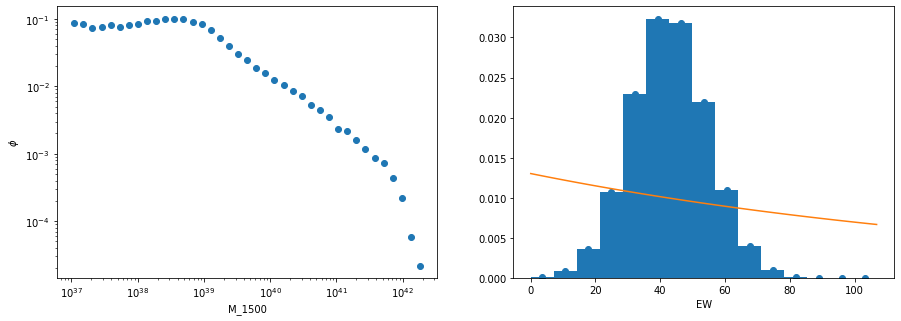

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

av_bin_obs1500, counts_obs1500, zeros_obs1500 = Lya_lumfunction(L_1500, 40)
ax[0].scatter(av_bin_obs1500, counts_obs1500)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('M_1500')
ax[0].set_ylabel(r'$\phi$')


counts_ew, bins_ew = np.histogram(EW, bins=15, density=True)
bins_cen_ew = (bins_ew[1:]+bins_ew[:-1])/2
ax[1].hist(EW, bins=15, density=True)
ax[1].scatter(bins_cen_ew, counts_ew)
def exponential(x, w0, N):
    return N*np.exp(-x/w0)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(exponential, bins_cen_ew, counts_ew, p0=[95, 40000]) 
ew_lin = np.linspace(np.min(EW), np.max(EW), 100)
ax[1].plot(ew_lin, exponential(ew_lin, popt[0], popt[1]))
ax[1].set_xlabel('EW')
print(popt[0])

Text(0, 0.5, 'L_lya')

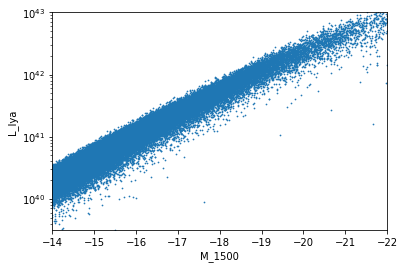

In [8]:
plt.scatter(M_1500, L_lya_obs, s=0.5)
plt.yscale('log')
plt.xlim(-14,-22)
plt.ylim(10**(39.5), 1e43)
plt.xlabel('M_1500')
plt.ylabel('L_lya')

(10000000, 1000000000000)

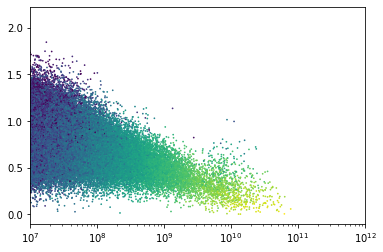

In [9]:
plt.scatter(Mass_stel,f, s=0.5, c=np.log10(SFR))
plt.xscale('log')
plt.xlim(10**7, 10**12)

## Byrhol

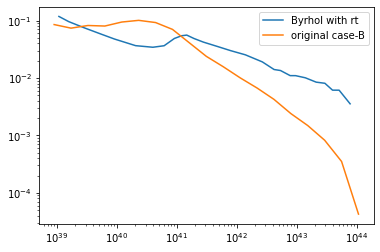

In [357]:
data_rt = np.genfromtxt('byrhol_rt.txt')
plt.plot(10**data_rt[:,0], 10**data_rt[:,1], label='Byrhol with rt')
plt.plot(av_bin, counts, label='original case-B')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [62]:
generic_name = '/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/'
specific_name = 'snapshot_012_z003p017/snap_012_z003p017.'

import h5py as h5
import read_eagle
h5py.enable_ipython_completer()

snapfile = generic_name+specific_name+'0.hdf5'

with h5.File(snapfile,'r') as f:
    num_files = f['Header'].attrs['NumFilesPerSnapshot']
        

metallicity = []
for i in range(num_files):
    myfile = read_eagle.EagleSnapshot(generic_name + specific_name+'%d.hdf5' %(i))
    myfile.select_region(0.1,0.2,0.1,0.2,0.1,0.2)
    metallicity.append(np.array(myfile.read_dataset(0, "Metallicity")))
#NumFilesPerSnapshot = myfile'/Header'.attrs['NumFilesPerSnapshot']

'''
NumFilesPerSnapshot = myfile['Header'].attrs['NumFilesPerSnapshot']
#myfile.close()
print(NumFilesPerSnapshot)

myfile1 = generic_name+specific_name[0]+'0.hdf5'
myfile = h5py.File(myfile1, 'r')

snap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.")

delta_c = 0.2

num_halos=2
#np.random.seed(99)
#halos_ind = np.random.randint(0, len(Pos[0]), num_halos)
halos_ind=[0,72257]

pos_part = []
temp = []
density = []
metallicity = []

for i in halos_ind:
    snap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.0.hdf5")
    delta_c = 0.3
    snap.select_region(Pos[0][i,0]-delta_c, Pos[0][i,0]+delta_c, Pos[0][i,1]-delta_c, Pos[0][i,1]+delta_c, Pos[0][i,2]-delta_c, Pos[0][i,2]+delta_c)
    pos_part.append(snap.read_dataset(0, "Coordinates"))#0 = particle type
    temp.append(snap.read_dataset(0, "Temperature"))
    density.append(np.array(snap.read_dataset(0, "Density")))
    metallicity.append(np.array(snap.read_dataset(0, "Metallicity")))
    #ids.append(np.array(snap.read_dataset(0, "ParticleIDs")))
    del snap'''

'\nNumFilesPerSnapshot = myfile[\'Header\'].attrs[\'NumFilesPerSnapshot\']\n#myfile.close()\nprint(NumFilesPerSnapshot)\n\nmyfile1 = generic_name+specific_name[0]+\'0.hdf5\'\nmyfile = h5py.File(myfile1, \'r\')\n\nsnap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.")\n\ndelta_c = 0.2\n\nnum_halos=2\n#np.random.seed(99)\n#halos_ind = np.random.randint(0, len(Pos[0]), num_halos)\nhalos_ind=[0,72257]\n\npos_part = []\ntemp = []\ndensity = []\nmetallicity = []\n\nfor i in halos_ind:\n    snap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.0.hdf5")\n    delta_c = 0.3\n    snap.select_region(Pos[0][i,0]-delta_c, Pos[0][i,0]+delta_c, Pos[0][i,1]-delta_c, Pos[0][i,1]+delta_c, Pos[0][i,2]-delta_c, Pos[0][i,2]+delta_c)\n    pos_part.append(snap.read_dataset(0, "Coordinates"))#0 = particle type\n    temp.append(snap.read_

In [63]:
print(metallicity)

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=fl